In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.visualization import make_lupton_rgb

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(100)

In [3]:
# check the MIST_PATH environment variable
if "MIST_PATH" not in os.environ:
    raise Exception("MIST_PATH environment variable is not set.  This should be set to the location of the MIST code repository.")

In [11]:
artpop.filters.phot_system_list

['HST_WFC3',
 'HST_ACSWF',
 'SDSSugriz',
 'CFHTugriz',
 'DECam',
 'HSC',
 'JWST',
 'LSST',
 'UBVRIplus',
 'UKIDSS',
 'WFIRST',
 'GALEX']

In [12]:
artpop.filters.get_filter_names("HSC")

['hsc_g', 'hsc_r', 'hsc_i', 'hsc_z', 'hsc_y', 'hsc_nb816', 'hsc_nb921']

In [49]:
artpop.filters.get_filter_names("HST_ACSWF")

['ACS_WFC_F435W',
 'ACS_WFC_F475W',
 'ACS_WFC_F502N',
 'ACS_WFC_F550M',
 'ACS_WFC_F555W',
 'ACS_WFC_F606W',
 'ACS_WFC_F625W',
 'ACS_WFC_F658N',
 'ACS_WFC_F660N',
 'ACS_WFC_F775W',
 'ACS_WFC_F814W',
 'ACS_WFC_F850LP',
 'ACS_WFC_F892N']

In [42]:
iso = artpop.MISTIsochrone(
    log_age = 10.0,          # log of age in years
    feh = -0.75,             # metallicity [Fe/H]
    phot_system = 'HSC', # photometric system(s)
)

# normalize the IMF by number
mean_mag = iso.ssp_mag('hsc_i', norm_type='number')

# For Zangetsu, g-r ~ 0.64; g-i ~ 0.83
print(iso.ssp_color('hsc_g', 'hsc_r'))
print(iso.ssp_color('hsc_g', 'hsc_i'))

0.6177136018797454
0.9023518886625526


In [57]:
iso.ssp_mean_star_mass('kroupa')

0.30347356932140684

In [6]:
# For LCDM cosmology with H0=70, Om0=0.3, Tcmb0=2.725
# At redshift 0.006, the luminosity distance is 25.83 Mpc
# At redshift 0.004, the luminosity distance is 17.19 Mpc
# At redshift 0.002, the luminosity distance is 8.59 Mpc

In [44]:
distance = 25 * u.Mpc
pixel_scale = 0.168

num_stars_per_pix = artpop.constant_sb_stars_per_pix(
    sb = 25.7,                  # surface brightness
    mean_mag = mean_mag,      # mean stellar magnitude
    distance = distance,      # distance to system
    pixel_scale = pixel_scale # pixel scale in arcsec/pixel
)
print(f'number of stars per pixel = {num_stars_per_pix:.2f}')

number of stars per pixel = 2524.54


# z=0.06 galaxy; 10^7 Msun

- SSP's mean stellar mass is around 0.3 Msun
- So 10^7 Msun translates to ~3x10^7 stars.
- SSP's colors roughly match to the observed one

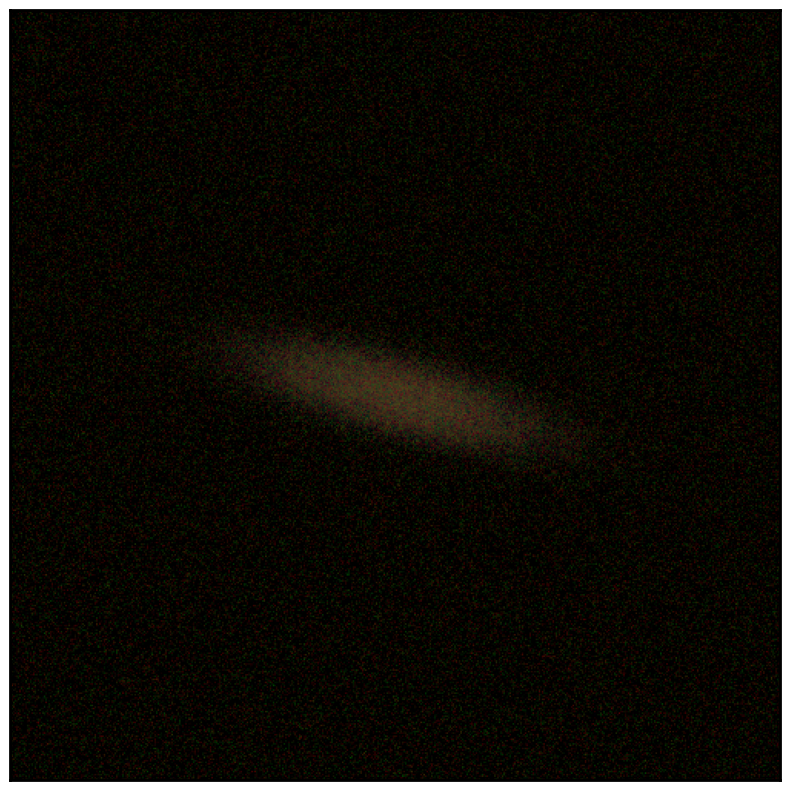

In [63]:
# create young, metal poor SSP source at 5 Mpc
src = artpop.MISTSersicSSP(
    log_age = 10.0,        # log of age in years
    feh = -0.75,            # metallicity [Fe/H]
    r_eff = 1.5 * u.kpc,   # effective radius
    n = 0.4,              # Sersic index
    theta = 165 * u.deg,  # position angle
    ellip = 0.75,          # ellipticity
    num_stars = 3e7,      # number of stars
    phot_system = 'HSC', # photometric system
    distance = 25 * u.Mpc, # distance to system
    xy_dim = 501,         # image dimension
    pixel_scale = 0.168,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

# HST ACS/WFC pixel size: 0.05 arcsec/pixel
# Subaru Hyper Suprime-Cam pixel size: 0.168 arcsec/pixel

# instantiate an imager object
imager = artpop.ArtImager(
    phot_system = 'HSC', # photometric system
    diameter = 8.0 * u.m, # effective aperture diameter
    read_noise = 4,       # read noise in electrons
    efficiency = 0.7,     # system efficiency
    random_state = rng    # random state for reproducibility
)

# PSF with 0.8'' seeing
psf = artpop.moffat_psf(fwhm=0.8 * u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'hsc_g',  # bandpass of observation
    exptime = 200 * u.min, # exposure time
    sky_sb = 22,          # sky surface brightness
    psf = psf             # point spread function
)

#artpop.show_image(obs_g.image);

obs_r = imager.observe(src, 'hsc_r', 15 * u.min, sky_sb=21, psf=psf)
obs_i = imager.observe(src, 'hsc_i', 30 * u.min, sky_sb=20, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.5)

artpop.show_image(rgb);

In [ ]:
# HST/ACS COSMOS survey exposure time: 2028 sec
# F814W band sky brightness: 

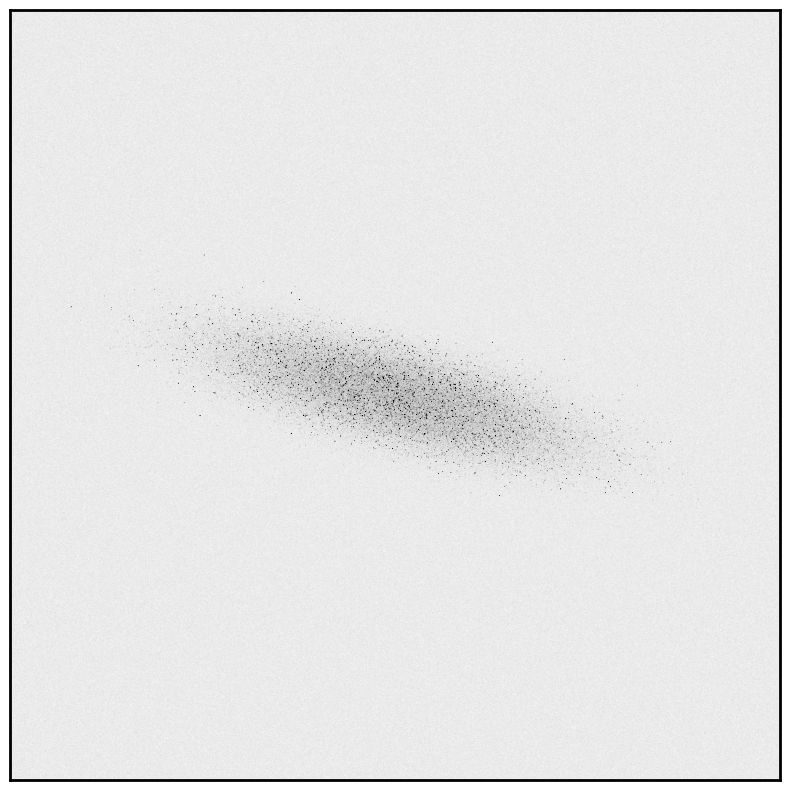

In [65]:
# create young, metal poor SSP source at 5 Mpc
src = artpop.MISTSersicSSP(
    log_age = 10.0,        # log of age in years
    feh = -0.75,            # metallicity [Fe/H]
    r_eff = 1.5 * u.kpc,   # effective radius
    n = 0.4,              # Sersic index
    theta = 165 * u.deg,  # position angle
    ellip = 0.75,          # ellipticity
    num_stars = 3e7,      # number of stars
    phot_system = 'HST_ACSWF', # photometric system
    distance = 25 * u.Mpc, # distance to system
    xy_dim = 1501,         # image dimension
    pixel_scale = 0.05,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

# HST ACS/WFC pixel size: 0.05 arcsec/pixel
# Subaru Hyper Suprime-Cam pixel size: 0.168 arcsec/pixel

# instantiate an imager object
imager = artpop.ArtImager(
    phot_system = 'HST_ACSWF', # photometric system
    diameter = 2.5 * u.m, # effective aperture diameter
    read_noise = 2.5,       # read noise in electrons
    efficiency = 0.8,     # system efficiency
    random_state = rng    # random state for reproducibility
)

# PSF with 0.8'' seeing
psf = artpop.moffat_psf(fwhm=0.12 * u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'ACS_WFC_F814W',  # bandpass of observation
    exptime = 35 * u.min, # exposure time
    sky_sb = 28,          # sky surface brightness
    psf = psf             # point spread function
)

artpop.show_image(obs_g.image);